# Lab 2: Text Mining - SMS Spam Collection 
by Group 8: Lu Han, Tony Chan, Michaela Hrabetova, Sangeeta Khanna, Cristina Endara

# Original Source

Work is based on SMS: Spam or Ham (Beginner) by deja vu on [kaggle.com](https://www.kaggle.com/dejavu23/sms-spam-or-ham-beginner/notebook).

There are heavy modifications to the original work for enhancements, improvements and fixes to make the original code work for this Juypter Notebook presentation and eventually implemented in an online Dash App.

# Notebook Setup

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import wordcloud

import nltk
from nltk.corpus import stopwords

In [2]:
spam_data = pd.read_csv("../input/spam.csv", encoding='latin-1')
spam_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Dataset Characteristics

In [3]:
spam_data.shape

(5572, 5)

In [4]:
spam_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


# Data Cleansing

## Cleaning up the dataframe

In [5]:
spam_data  = spam_data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
spam_data = spam_data.rename(columns={"v1":"label", "v2":"text"})

In [6]:
spam_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
spam_data.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [8]:
spam_data.groupby("label").describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

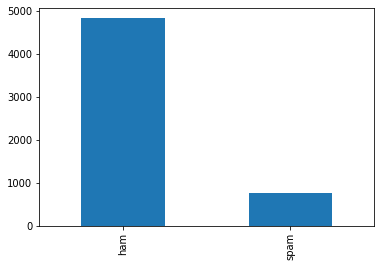

In [9]:
spam_data.label.value_counts().plot.bar();

## Labeling Categorical Data into Spam:1, Ham:0

In [10]:
spam_data['spam'] = spam_data['label'].map( {'spam': 1, 'ham': 0} ).astype(int)
spam_data.head(5)

,label,text,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


## Counting Number of Characters in Text Msg

In [11]:
spam_data['length'] = spam_data['text'].apply(len)
spam_data.head(5)

,label,text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


(-40.0, 950.0)

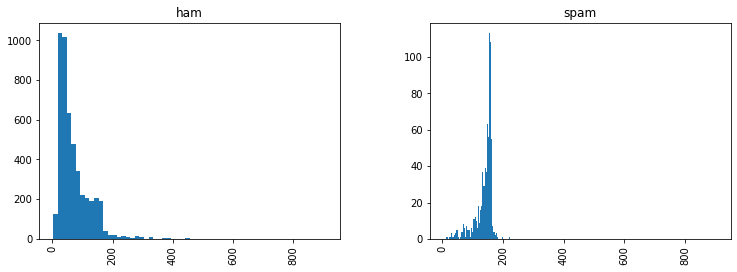

In [12]:
spam_data.hist(column='length',by='label',bins=60,figsize=(12,4))
plt.xlim(-40,950)

## Is there empty text?

In [13]:
spam_data[spam_data['text'].isna()].shape

(0, 4)

so there's no empty cell in our text data...

## Removing Stopwords

In [14]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
# if you don't have this package, you need to download it first
# nltk.download('stopwords')

In [16]:
# from nltk.corpus import stopwords
# stopwords.words("english")[100:110]

In [17]:
def remove_punctuation_and_stopwords(sms):
    
    sms_no_punctuation = [ch for ch in sms if ch not in string.punctuation]
    sms_no_punctuation = "".join(sms_no_punctuation).split()
    
    sms_no_punctuation_no_stopwords = \
        [word.lower() for word in sms_no_punctuation if word.lower() not in stopwords.words("english")]
        
    return sms_no_punctuation_no_stopwords

In [18]:
spam_data['filtered_text'] = spam_data['text'].apply(remove_punctuation_and_stopwords)
spam_data.head(5)

,label,text,spam,length,filtered_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,0,29,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,0,49,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,"[nah, dont, think, goes, usf, lives, around, t..."


In [19]:
# we will join the list into a string
spam_data['filtered_text'] = spam_data['filtered_text'].apply(lambda x: ' '.join(map(str, x)))

## Characteristics of a Ham or Spam message as shown in Word Cloud

In [20]:
data_ham  = spam_data[spam_data['spam'] == 0].copy()
data_spam = spam_data[spam_data['spam'] == 1].copy()

In [21]:
def show_wordcloud(data_spam_or_ham, title):
    text = ' '.join(data_spam_or_ham['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

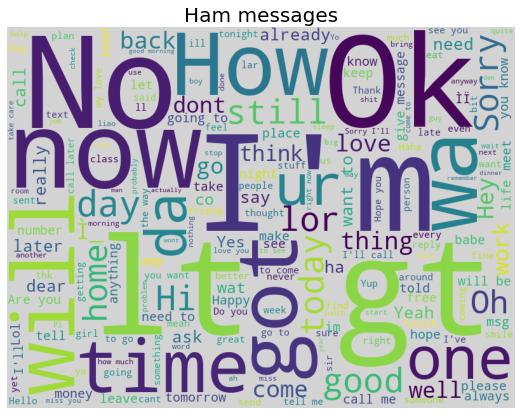

In [22]:
show_wordcloud(data_ham, "Ham messages")

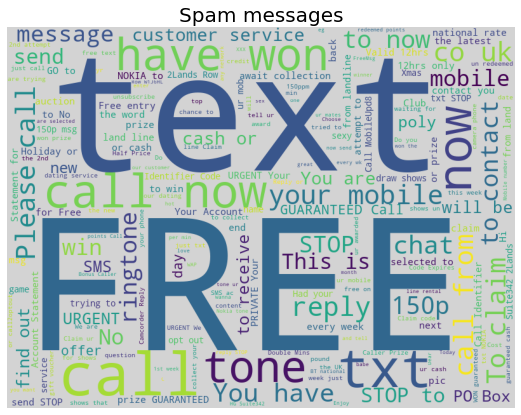

In [23]:
show_wordcloud(data_spam, "Spam messages")

# Feature extraction from SMS text

## Count Vectorizer

In [24]:
cvec = CountVectorizer()
C = cvec.fit(spam_data['filtered_text'])
C_trans = cvec.fit_transform(spam_data['filtered_text'])

## TFIVDF Vectorizer

In [25]:
tvec = TfidfVectorizer()
T = tvec.fit(spam_data['filtered_text'])
T_trans = tvec.fit_transform(spam_data['filtered_text'])

we will see how the vocab gets picked up by vectorizers

In [26]:
C_trans.shape

(5572, 9376)

In [27]:
T_trans.shape

(5572, 9376)

In [28]:
C_trans

<5572x9376 sparse matrix of type '<class 'numpy.int64'>'
	with 47254 stored elements in Compressed Sparse Row format>

In [29]:
T_trans

<5572x9376 sparse matrix of type '<class 'numpy.float64'>'
	with 47254 stored elements in Compressed Sparse Row format>

In [30]:
sample = spam_data['text'][8]
sam = C.transform([sample])
print(sample)
print(sam)

WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
  (0, 217)	1
  (0, 323)	1
  (0, 903)	1
  (0, 1928)	1
  (0, 2204)	2
  (0, 2265)	1
  (0, 2550)	1
  (0, 4208)	1
  (0, 4766)	1
  (0, 5713)	1
  (0, 6543)	1
  (0, 6778)	1
  (0, 6949)	1
  (0, 7212)	1
  (0, 8695)	1
  (0, 8699)	1
  (0, 9028)	1
  (0, 9303)	1


In [31]:
sam = T.transform([sample])
print(sample)
print(sam)

WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
  (0, 9303)	0.29530860208180876
  (0, 9028)	0.22455830783087213
  (0, 8699)	0.2309770790757037
  (0, 8695)	0.21315792858515895
  (0, 7212)	0.20578083334157685
  (0, 6949)	0.24558400935040767
  (0, 6778)	0.2819039811422981
  (0, 6543)	0.1713505108825306
  (0, 5713)	0.20578083334157685
  (0, 4766)	0.2819039811422981
  (0, 4208)	0.2160345127909193
  (0, 2550)	0.18342112351874904
  (0, 2265)	0.20469680629010817
  (0, 2204)	0.32625726899669705
  (0, 1928)	0.11047133827588144
  (0, 903)	0.24210080513346727
  (0, 323)	0.22656254952466967
  (0, 217)	0.2819039811422981


## Train Test Split from TFIDF
We will do a Train Test Split using TFIDF set to train and verify our models based on this particular spam dataset.

In [32]:
np.shape(T_trans)

(5572, 9376)

In [33]:
y = spam_data.iloc[:, 2].values
y

array([0, 0, 1, ..., 0, 0, 0])

In [34]:
T_matrix_trans = T_trans.A

In [35]:
Xt_train, Xt_test, yt_train, yt_test = train_test_split(T_matrix_trans, y, test_size=0.25)

In [36]:
Xt_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
yt_train

array([0, 0, 0, ..., 0, 0, 0])

## Choosing the right estimator
We will try these estimators according to scikit-learn algorithm cheat-sheet [here](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

1. SVC
2. LinearSVC
3. Naive Bayes
4. KNeighbors Classifier

## 1. SVC

In [38]:
SVC_model = SVC()
SVC_model.fit(Xt_train, yt_train)

SVC()

In [39]:
%%time
yt_pred_SVC = SVC_model.predict(Xt_test)
SVC_acc = accuracy_score(yt_test, yt_pred_SVC)
print("SVC Accuracy: ", SVC_acc)

SVC Accuracy:  0.9712849964106246
CPU times: user 30.1 s, sys: 60.8 ms, total: 30.2 s
Wall time: 30.2 s


## 2. LinearSVC

In [40]:
LSVC_model = LinearSVC()
LSVC_model.fit(Xt_train, yt_train)

LinearSVC()

In [41]:
%%time
yt_pred_LSVC = LSVC_model.predict(Xt_test)
LSVC_acc = accuracy_score(yt_test, yt_pred_LSVC)
print("Linear SVC Accuracy: ", LSVC_acc)

Linear SVC Accuracy:  0.9806173725771715
CPU times: user 20.3 ms, sys: 3.42 ms, total: 23.7 ms
Wall time: 9.57 ms


## 3. Naive Bayes

In [42]:
NB_model = MultinomialNB()
NB_model.fit(Xt_train, yt_train)

MultinomialNB()

In [43]:
%%time
yt_pred_NB = NB_model.predict(Xt_test)
print("Naive Bayes Accuracy: ", accuracy_score(yt_test, yt_pred_NB))

Naive Bayes Accuracy:  0.9612347451543432
CPU times: user 28.6 ms, sys: 14 ms, total: 42.5 ms
Wall time: 12.6 ms


## 4. KNeighbors Classifier

In [44]:
KNN_model = KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(Xt_train, yt_train)

KNeighborsClassifier()

In [45]:
%%time
yt_pred_KN = KNN_model.predict(Xt_test)
print("KNN Accuracy: ", accuracy_score(yt_test, yt_pred_KN))


KNN Accuracy:  0.9016511127063891
CPU times: user 1min 7s, sys: 181 ms, total: 1min 7s
Wall time: 1min 7s


## Accuracy vs Time Chart
| Model | Time | Accuracy |
|-------|------|----------|
| SVC |  30.9s | 0.966 |
| Linear SVC | 11.2ms | 0.974 |
| Naive Bayes | 13.1ms | 0.958 |
| KNN | 60.7s | 0.903

Therefore, Linear SVC predicts faster and gets more reliable results. We will be using this for our Dash App implementation for this particular set of data.

In [46]:
# We save our cleaned csv for the spam engine
# spam_data.to_csv('../data/spam_cleaned.csv')